#### Repeating the Same Process - Ground Truth Climate & WNV Case Data 

We will see how actual climatic data compares with the embeddings. 

By: Angel Moreno

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import pickle
import warnings
import logging

from pytorch_tabnet.tab_model import TabNetRegressor
import shap

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from kneed import KneeLocator

import torch
import optuna 
from optuna.samplers import TPESampler

#### Data Cleaning - Compiling 8 Clean CSVs Ready for Analysis 	

The goal of this section is to have one csv with all climate, water, and ndvi data for each of 2017 to 2024.

In [160]:
df_climate = pd.read_csv("../input/anuj_true_data_csvs/Angel_ClimateData.csv")

In [161]:
# climate data
df_climate = pd.read_csv("../input/anuj_true_data_csvs/Angel_ClimateData.csv")
# water data
df_water = pd.read_csv("../input/anuj_true_data_csvs/Angel_WaterData.csv")
# mean ndvi data
df_ndvi = pd.read_csv("../input/anuj_true_data_csvs/Angel_meanNDVI.csv")

As seen below, the ordering of counties should be consistent across all, so we may merge horizontally in place. I will also check this with one of my master csvs with the normalized human case data column.

In [162]:
case_data_ex = pd.read_csv("../finished_csvs/master_2022.csv")
case_data_ex.columns

Index(['County', 'GEOID', 'A00', 'A01', 'A02', 'A03', 'A04', 'A05', 'A06',
       'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16',
       'A17', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26',
       'A27', 'A28', 'A29', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36',
       'A37', 'A38', 'A39', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46',
       'A47', 'A48', 'A49', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56',
       'A57', 'A58', 'A59', 'A60', 'A61', 'A62', 'A63', 'Cases_2022',
       '2022_population', 'Cases_2022_normalized'],
      dtype='object')

In [163]:
print(df_climate.head()["County_1"].iloc[:5])
print(df_ndvi.head()["County_1"].iloc[:5])

# this should be 102 if all are equal
print(sum((df_climate["County_1"] == df_ndvi["County_1"])*1)==102)

0        Adams
1    Alexander
2         Bond
3        Boone
4        Brown
Name: County_1, dtype: object
0        Adams
1    Alexander
2         Bond
3        Boone
4        Brown
Name: County_1, dtype: object
True


In [164]:
# now I am checking for my data
print(sum((case_data_ex["County"] == df_climate["County_1"])*1)==102)

print(case_data_ex["County"].is_monotonic_increasing) # seems like my county names are only alphabetical
print(df_climate["County_1"].is_monotonic_increasing)
print(df_ndvi["County_1"].is_monotonic_increasing)

False
True
False
False


I will reorder my dataframe to fit ordering of df_climate / df_ndvi.

In [165]:
source_order = df_climate["County_1"].unique()
case_data_ex["County"] = pd.Categorical(case_data_ex["County"], categories=source_order, ordered=True)
case_data_ex

,County,GEOID,A00,A01,A02,A03,A04,A05,A06,A07,...,A57,A58,A59,A60,A61,A62,A63,Cases_2022,2022_population,Cases_2022_normalized
0,Adams,17001.0,-0.067239,-0.065779,0.061984,-0.170445,0.049984,-0.109669,-0.038933,0.111507,...,0.080336,0.056306,-0.019753,-0.151427,-0.078184,-0.160633,0.029502,0.0,64526,0.0
1,Alexander,17003.0,-0.100853,-0.048913,-0.008852,-0.076554,0.005164,-0.063323,0.025426,0.088139,...,0.095372,0.059891,-0.053308,-0.080305,-0.104070,-0.095462,0.045853,0.0,4859,0.0
2,Bond,17005.0,-0.108974,-0.064307,0.034625,-0.117393,0.029814,-0.072641,0.010907,0.111090,...,0.107193,0.020510,-0.093062,-0.128969,-0.062519,-0.157703,0.039234,0.0,16716,0.0
3,Boone,17007.0,-0.036726,-0.081128,0.083217,-0.217778,0.037748,-0.126451,-0.065230,0.112206,...,0.052234,0.042340,-0.109492,-0.138152,-0.037796,-0.157798,0.055174,0.0,53084,0.0
4,Brown,17009.0,-0.074731,-0.040546,0.053104,-0.123806,0.062233,-0.120984,-0.025486,0.138768,...,0.079358,0.054082,0.003168,-0.142994,-0.088903,-0.159073,0.031018,0.0,6321,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Whiteside,17195.0,-0.050599,-0.101328,0.046094,-0.203955,0.018187,-0.152153,-0.070677,0.122247,...,0.056901,0.040895,-0.099173,-0.156041,-0.027092,-0.142284,0.059885,0.0,54602,0.0
98,Will,17197.0,-0.038191,-0.143632,0.087410,-0.183026,0.077733,-0.091773,-0.084821,0.025606,...,0.062069,0.073197,-0.041747,-0.089485,-0.062679,-0.148837,0.036766,0.0,699110,0.0
99,Williamson,17199.0,-0.145247,-0.065627,-0.006135,-0.022172,0.025129,-0.067894,-0.011457,0.082523,...,0.126538,0.035682,-0.020514,-0.103149,-0.110587,-0.128714,0.016842,0.0,66565,0.0
100,Winnebago,17201.0,-0.030881,-0.128900,0.081142,-0.183157,0.051611,-0.116952,-0.079821,0.111883,...,0.063265,0.038038,-0.039094,-0.120788,-0.049664,-0.163948,0.032393,0.0,282081,0.0


In [166]:
print(sum(case_data_ex["County"] == df_climate["County_1"])*1)

print(list(case_data_ex["County"].unique()))
print(list(df_climate["County_1"].unique()))

82
['Adams', 'Alexander', 'Bond', 'Boone', 'Brown', 'Bureau', 'Calhoun', 'Carroll', 'Cass', 'Champaign', 'Christian', 'Clark', 'Clay', 'Clinton', 'Coles', 'Cook', 'Crawford', 'Cumberland', 'De Witt', 'DeKalb', 'Douglas', 'DuPage', 'Edgar', 'Edwards', 'Effingham', 'Fayette', 'Ford', 'Franklin', 'Fulton', 'Gallatin', 'Greene', 'Grundy', 'Hamilton', 'Hancock', 'Hardin', 'Henderson', 'Henry', 'Iroquois', 'Jackson', 'Jasper', 'Jefferson', 'Jersey', 'Jo Daviess', 'Johnson', 'Kane', 'Kankakee', 'Kendall', 'Knox', 'LaSalle', 'Lake', 'Lawrence', 'Lee', 'Livingston', 'Logan', 'Macon', 'Macoupin', 'Madison', 'Marion', 'Marshall', 'Mason', 'Massac', 'McDonough', 'McHenry', 'McLean', 'Menard', 'Mercer', 'Monroe', 'Montgomery', 'Morgan', 'Moultrie', 'Ogle', 'Peoria', 'Perry', 'Piatt', 'Pike', 'Pope', 'Pulaski', 'Putnam', 'Randolph', 'Richland', 'Rock Island', 'Saline', 'Sangamon', 'Schuyler', 'Scott', 'Shelby', 'St. Clair', 'Stark', 'Stephenson', 'Tazewell', 'Union', 'Vermilion', 'Wabash', 'Warren',

In [167]:
case_data_ex = case_data_ex.sort_values("County")
print(list(case_data_ex["County"].unique()))
print(list(df_climate["County_1"].unique()))

# IMPORTANT: RESET INDEX TO COMPARE SINCE I SHIFTED STUFF AROUND
print(sum(case_data_ex["County"].reset_index(drop=True) == df_climate["County_1"].reset_index(drop=True))*1)

['Adams', 'Alexander', 'Bond', 'Boone', 'Brown', 'Bureau', 'Calhoun', 'Carroll', 'Cass', 'Champaign', 'Christian', 'Clark', 'Clay', 'Clinton', 'Coles', 'Cook', 'Crawford', 'Cumberland', 'DeKalb', 'De Witt', 'Douglas', 'DuPage', 'Edgar', 'Edwards', 'Effingham', 'Fayette', 'Ford', 'Franklin', 'Fulton', 'Gallatin', 'Greene', 'Grundy', 'Hamilton', 'Hancock', 'Hardin', 'Henderson', 'Henry', 'Iroquois', 'Jackson', 'Jasper', 'Jefferson', 'Jersey', 'Jo Daviess', 'Johnson', 'Kane', 'Kankakee', 'Kendall', 'Knox', 'Lake', 'LaSalle', 'Lawrence', 'Lee', 'Livingston', 'Logan', 'McDonough', 'McHenry', 'McLean', 'Macon', 'Macoupin', 'Madison', 'Marion', 'Marshall', 'Mason', 'Massac', 'Menard', 'Mercer', 'Monroe', 'Montgomery', 'Morgan', 'Moultrie', 'Ogle', 'Peoria', 'Perry', 'Piatt', 'Pike', 'Pope', 'Pulaski', 'Putnam', 'Randolph', 'Richland', 'Rock Island', 'St. Clair', 'Saline', 'Sangamon', 'Schuyler', 'Scott', 'Shelby', 'Stark', 'Stephenson', 'Tazewell', 'Union', 'Vermilion', 'Wabash', 'Warren', 'W

In [168]:
df_climate

,County_1,FIPS,State,Population,X,Y,Hum_17,Pre_17,Tmax_17,Tmin_17,...,Hum_23,Pre_23,Tmax_23,Tmin_23,WS_23,Hum_24,Pre_24,Tmax_24,Tmin_24,WS_24
0,Adams,17001,Illinois,65435,-91.1848,39.9877,83.489720,2.414575,28.878265,16.430389,...,80.156819,2.598919,28.812063,16.643852,3.509917,86.957233,2.887003,28.874651,17.100551,3.662825
1,Alexander,17003,Illinois,5761,-89.3379,37.1964,92.409081,1.849715,29.800494,18.060720,...,92.354838,4.627896,29.968267,18.333393,2.979814,94.356359,3.490334,30.109471,18.601800,3.123587
2,Bond,17005,Illinois,16426,-89.4356,38.8868,87.526342,2.671293,29.578461,16.664752,...,87.931722,3.354472,28.878770,16.415715,3.666769,90.279601,3.576298,29.501770,17.693506,3.822610
3,Boone,17007,Illinois,53544,-88.8234,42.3231,94.299354,3.828716,26.579441,13.915454,...,84.941611,3.024114,26.706373,14.315155,3.842082,92.348444,3.880356,27.161379,14.746334,3.891934
4,Brown,17009,Illinois,6578,-90.7503,39.9618,86.754199,2.218834,28.874032,15.834936,...,83.882595,2.443424,28.595510,16.055039,3.595764,89.503626,3.176027,28.790812,16.788935,3.769309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Whiteside,17195,Illinois,55175,-89.9123,41.7553,90.371500,3.071367,27.478812,14.891202,...,82.829832,2.374838,27.772224,15.295255,3.415740,89.602076,3.247248,27.904806,15.772279,3.454726
98,Will,17197,Illinois,690743,-87.9787,41.4450,91.886131,2.779096,27.584172,14.851429,...,87.019067,3.472279,27.124073,14.942312,3.475865,90.327146,3.290599,28.393179,15.664390,3.600911
99,Williamson,17199,Illinois,66597,-88.9299,37.7303,90.827954,2.335025,29.802950,17.611845,...,91.053690,4.186029,30.152616,17.835427,2.890200,92.386553,3.691179,30.178877,18.317548,2.992142
100,Winnebago,17201,Illinois,282572,-89.1608,42.3363,93.717256,3.636186,26.617381,14.118006,...,82.816904,2.648312,27.056700,14.645746,3.844946,91.906219,3.870281,27.436860,14.906896,3.896780


In [169]:
print(df_climate.columns)
print(df_climate.shape)

Index(['County_1', 'FIPS', 'State', 'Population', 'X', 'Y', 'Hum_17', 'Pre_17',
       'Tmax_17', 'Tmin_17', 'WS_17', 'Hum_18', 'Pre_18', 'Tmax_18', 'Tmin_18',
       'WS_18', 'Hum_19', 'Pre_19', 'Tmax_19', 'Tmin_19', 'WS_19', 'Hum_20',
       'Pre_20', 'Tmax_20', 'Tmin_20', 'WS_20', 'Hum_21', 'Pre_21', 'Tmax_21',
       'Tmin_21', 'WS_21', 'Hum_22', 'Pre_22', 'Tmax_22', 'Tmin_22', 'WS_22',
       'Hum_23', 'Pre_23', 'Tmax_23', 'Tmin_23', 'WS_23', 'Hum_24', 'Pre_24',
       'Tmax_24', 'Tmin_24', 'WS_24'],
      dtype='object')
(102, 46)


In [170]:
print(df_water.columns)
print(df_water.shape)

Index(['FID', 'LSTNight_2017', 'LSTDay_2017', 'Chlorophyll_2017',
       'LSTNight_2018', 'LSTDay_2018', 'Chlorophyll_2018', 'LSTNight_2019',
       'LSTDay_2019', 'Chlorophyll_2019', 'LSTNight_2020', 'LSTDay_2020',
       'Chlorophyll_2020', 'LSTNight_2021', 'LSTDay_2021', 'Chlorophyll_2021',
       'LSTNight_2022', 'LSTDay_2022', 'Chlorophyll_2022', 'LSTNight_2023',
       'LSTDay_2023', 'Chlorophyll_2023', 'LSTNight_2024', 'LSTDay_2024',
       'Chlorophyll_2024'],
      dtype='object')
(102, 25)


In [171]:
print(df_ndvi.columns)
print(df_ndvi.shape)

Index(['County_1', 'FIPS', 'State', 'Population', 'X', 'Y', 'Ag_MEAN_2017',
       'Ag_MEAN_2018', 'Ag_MEAN_2019', 'Ag_MEAN_2020', 'Ag_MEAN_2021',
       'Ag_MEAN_2022', 'Ag_MEAN_2023', 'Ag_MEAN_2024', 'Fs_MEAN_2017',
       'Fs_MEAN_2018', 'Fs_MEAN_2019', 'Fs_MEAN_2020', 'Fs_MEAN_2021',
       'Fs_MEAN_2022', 'Fs_MEAN_2023', 'Fs_MEAN_2024', 'Rn_MEAN_2017',
       'Rn_MEAN_2018', 'Rn_MEAN_2019', 'Rn_MEAN_2020', 'Rn_MEAN_2021',
       'Rn_MEAN_2022', 'Rn_MEAN_2023', 'Rn_MEAN_2024'],
      dtype='object')
(102, 30)


In [172]:
df_master = pd.concat([df_climate, df_water, df_ndvi], axis=1)
df_master

,County_1,FIPS,State,Population,X,Y,Hum_17,Pre_17,Tmax_17,Tmin_17,...,Fs_MEAN_2023,Fs_MEAN_2024,Rn_MEAN_2017,Rn_MEAN_2018,Rn_MEAN_2019,Rn_MEAN_2020,Rn_MEAN_2021,Rn_MEAN_2022,Rn_MEAN_2023,Rn_MEAN_2024
0,Adams,17001,Illinois,65435,-91.1848,39.9877,83.489720,2.414575,28.878265,16.430389,...,0.80,0.81,0.76,0.76,0.77,0.74,0.79,0.78,0.77,0.7783
1,Alexander,17003,Illinois,5761,-89.3379,37.1964,92.409081,1.849715,29.800494,18.060720,...,0.84,0.84,0.67,0.65,0.65,0.68,0.68,0.60,0.59,0.6248
2,Bond,17005,Illinois,16426,-89.4356,38.8868,87.526342,2.671293,29.578461,16.664752,...,0.82,0.83,0.80,0.79,0.82,0.75,0.81,0.82,0.80,0.8093
3,Boone,17007,Illinois,53544,-88.8234,42.3231,94.299354,3.828716,26.579441,13.915454,...,0.81,0.80,0.76,0.73,0.79,0.74,0.79,0.80,0.75,0.7795
4,Brown,17009,Illinois,6578,-90.7503,39.9618,86.754199,2.218834,28.874032,15.834936,...,0.83,0.83,0.78,0.78,0.79,0.75,0.78,0.79,0.79,0.7871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Whiteside,17195,Illinois,55175,-89.9123,41.7553,90.371500,3.071367,27.478812,14.891202,...,0.80,0.80,0.74,0.69,0.77,0.74,0.73,0.75,NaN,0.7413
98,Will,17197,Illinois,690743,-87.9787,41.4450,91.886131,2.779096,27.584172,14.851429,...,0.75,0.75,0.75,0.77,0.78,0.70,0.78,0.78,NaN,0.7786
99,Williamson,17199,Illinois,66597,-88.9299,37.7303,90.827954,2.335025,29.802950,17.611845,...,0.82,0.81,0.77,0.72,NaN,0.75,NaN,0.78,NaN,0.7805
100,Winnebago,17201,Illinois,282572,-89.1608,42.3363,93.717256,3.636186,26.617381,14.118006,...,0.78,0.79,NaN,0.76,NaN,NaN,NaN,NaN,NaN,#DIV/0!


In [173]:
# storing the three consistent informative columns (county name, fips, and population as well if needed)
df_info = df_master.iloc[:, :4].drop(columns=["State"]).copy()
df_info

,County_1,FIPS,Population
0,Adams,17001,65435
1,Alexander,17003,5761
2,Bond,17005,16426
3,Boone,17007,53544
4,Brown,17009,6578
...,...,...,...
97,Whiteside,17195,55175
98,Will,17197,690743
99,Williamson,17199,66597
100,Winnebago,17201,282572


In [174]:
source_order = df_climate["County_1"].unique()

# test run for 2017 only
year_short = 2017-2000
df_2017 = pd.read_csv(f"../finished_csvs/master_20{year_short}.csv")

df_2017["County"] = pd.Categorical(df_2017["County"], categories=source_order, ordered=True)
df_2017 = df_2017.reset_index(drop=True)

# df for the curr year
# this uses regex to keep anything with 17

df_curr_2017_master = df_master.filter(regex=rf'{year_short}')

df_curr_2017_master = pd.concat([df_info, df_2017[f"Cases_20{year_short}_normalized"]], axis=1)
df_curr_2017_master

,County_1,FIPS,Population,Cases_2017_normalized
0,Adams,17001,65435,1.513844
1,Alexander,17003,5761,0.000000
2,Bond,17005,16426,0.000000
3,Boone,17007,53544,1.868705
4,Brown,17009,6578,0.000000
...,...,...,...,...
97,Whiteside,17195,55175,0.000000
98,Will,17197,690743,0.144827
99,Williamson,17199,66597,0.000000
100,Winnebago,17201,282572,1.053811


In [175]:
dfs = []
for year in np.arange(2017,2025):
	# use the cols identified earlier
	# so for df_climate, the year is only the last two digits
	year_short = year - 2000

	source_order = df_climate["County_1"].unique()

	df_cases = pd.read_csv(f"../finished_csvs/master_20{year_short}.csv")

	df_cases["County"] = pd.Categorical(df_cases["County"], categories=source_order, ordered=True)
	df_cases = df_cases.sort_values("County").reset_index(drop=True)

	df_master[f"Cases_normalized_20{year_short}"] = df_cases[f"Cases_20{year_short}_normalized"]

	if year == 2020:
		# matches cols matching _20
		df = df_master.filter(regex=rf'(?:_20|_2020)(?:_|$)')
	else:
		# df for the curr year
		df = df_master.filter(regex=rf'{year_short}')
	
	df = pd.concat([df_info, df], axis=1)

	dfs.append(df)
	df.to_csv(f"../finished_grnd_trth_csvs_fix/df_{year}.csv")

Small edit: instead of individual LSTDay and LSTNight columns, get LST_mean_``year``

Completing some additional quality checks: 
- some cells have value of ``#DIV/0!`` from xlsx
- some cells are NaN due to incomplete data

In [176]:
debugging = []

In [177]:
for year in np.arange(2017, 2025):
  df_curr = pd.read_csv(f"../finished_grnd_trth_csvs_fix/df_{year}.csv").drop(columns=["Unnamed: 0"])
  df_curr[f"LSTMean_{year}"] = ((df_curr[f"LSTNight_{year}"] + df_curr[f"LSTDay_{year}"]) / 2)
  col = df_curr.pop(f"LSTMean_{year}")
  df_curr.insert(8, f"LSTMean_{year}", col)
  df_curr = df_curr.drop(columns=[f"LSTNight_{year}", f"LSTDay_{year}"])
  
	#additional quality checks I found while manually checking csvs: 
  df_curr = df_curr.fillna(0)
  df_curr = df_curr.replace(["#DIV/0!"], 0)
  df_curr.to_csv(f"../grnd_trth_final_data/df_{year}_new.csv", index=False)
  debugging.append(df_curr)
  
df_curr

,County_1,FIPS,Population,Hum_24,Pre_24,Tmax_24,Tmin_24,WS_24,LSTMean_2024,Chlorophyll_2024,Ag_MEAN_2024,Fs_MEAN_2024,Rn_MEAN_2024,Cases_normalized_2024
0,Adams,17001,65435,86.957233,2.887003,28.874651,17.100551,3.662825,22.630,1.626381,0.80,0.81,0.7783,0.000000
1,Alexander,17003,5761,94.356359,3.490334,30.109471,18.601800,3.123587,23.345,1.590579,0.76,0.84,0.6248,0.000000
2,Bond,17005,16426,90.279601,3.576298,29.501770,17.693506,3.822610,23.070,1.548130,0.82,0.83,0.8093,0.000000
3,Boone,17007,53544,92.348444,3.880356,27.161379,14.746334,3.891934,20.740,1.502652,0.81,0.80,0.7795,0.000000
4,Brown,17009,6578,89.503626,3.176027,28.790812,16.788935,3.769309,22.375,1.826333,0.81,0.83,0.7871,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Whiteside,17195,55175,89.602076,3.247248,27.904806,15.772279,3.454726,21.440,1.716051,0.81,0.80,0.7413,0.000000
98,Will,17197,690743,90.327146,3.290599,28.393179,15.664390,3.600911,23.335,1.185811,0.78,0.75,0.7786,0.282253
99,Williamson,17199,66597,92.386553,3.691179,30.178877,18.317548,2.992142,23.705,1.384585,0.79,0.81,0.7805,0.000000
100,Winnebago,17201,282572,91.906219,3.870281,27.436860,14.906896,3.896780,21.115,1.356500,0.79,0.79,0,1.409493


In [178]:
for df in debugging:
  print(list(df.columns))

['County_1', 'FIPS', 'Population', 'Hum_17', 'Pre_17', 'Tmax_17', 'Tmin_17', 'WS_17', 'LSTMean_2017', 'Chlorophyll_2017', 'Ag_MEAN_2017', 'Fs_MEAN_2017', 'Rn_MEAN_2017', 'Cases_normalized_2017']
['County_1', 'FIPS', 'Population', 'Hum_18', 'Pre_18', 'Tmax_18', 'Tmin_18', 'WS_18', 'LSTMean_2018', 'Chlorophyll_2018', 'Ag_MEAN_2018', 'Fs_MEAN_2018', 'Rn_MEAN_2018', 'Cases_normalized_2018']
['County_1', 'FIPS', 'Population', 'Hum_19', 'Pre_19', 'Tmax_19', 'Tmin_19', 'WS_19', 'LSTMean_2019', 'Chlorophyll_2019', 'Ag_MEAN_2019', 'Fs_MEAN_2019', 'Rn_MEAN_2019', 'Cases_normalized_2019']
['County_1', 'FIPS', 'Population', 'Hum_20', 'Pre_20', 'Tmax_20', 'Tmin_20', 'WS_20', 'LSTMean_2020', 'Chlorophyll_2020', 'Ag_MEAN_2020', 'Fs_MEAN_2020', 'Rn_MEAN_2020', 'Cases_normalized_2020']
['County_1', 'FIPS', 'Population', 'Hum_21', 'Pre_21', 'Tmax_21', 'Tmin_21', 'WS_21', 'LSTMean_2021', 'Chlorophyll_2021', 'Ag_MEAN_2021', 'Fs_MEAN_2021', 'Rn_MEAN_2021', 'Cases_normalized_2021']
['County_1', 'FIPS', 'Pop

#### SHAP-TabNet Ranking for 2017-2024

In [42]:
#### use finished_grnd_trth_csvs ####

########### RUN ME ###########

# master data here
df_2017 = pd.read_csv("../grnd_trth_final_data/df_2017_new.csv")
df_2018 = pd.read_csv("../grnd_trth_final_data/df_2018_new.csv")
df_2019 = pd.read_csv("../grnd_trth_final_data/df_2019_new.csv")
df_2020 = pd.read_csv("../grnd_trth_final_data/df_2020_new.csv")
df_2021 = pd.read_csv("../grnd_trth_final_data/df_2021_new.csv")
df_2022 = pd.read_csv("../grnd_trth_final_data/df_2022_new.csv")
df_2023 = pd.read_csv("../grnd_trth_final_data/df_2023_new.csv")
df_2024 = pd.read_csv("../grnd_trth_final_data/df_2024_new.csv")

dfs = [df_2017, df_2018, df_2019, df_2020,
       df_2021, df_2022, df_2023, df_2024]

# drop the columns: 'County_1', 'FIPS', 'Population', 'Cases_normalized_2017'
# so we can get our X. 
example_X = df_2017.copy().drop(columns=['County_1', 'FIPS', 'Population', 'Cases_normalized_2017']).columns

# always at the end of the dfs
example_Y = df_2017.columns[-1]

print(f"Feature columns: {list(example_X)}")
print(f"Target column: {example_Y}")

Feature columns: ['Hum_17', 'Pre_17', 'Tmax_17', 'Tmin_17', 'WS_17', 'LSTMean_2017', 'Chlorophyll_2017', 'Ag_MEAN_2017', 'Fs_MEAN_2017', 'Rn_MEAN_2017']
Target column: Cases_normalized_2017


SHAP-TabNet Rankings for the True 2017-2024 data. 

In [180]:
print("Checking dfs list - year-specific columns:")
for i, df in enumerate(dfs):
    year_cols = [col for col in df.columns if any(str(y) in col for y in range(17, 25))]
    print(f"dfs[{i}]: year columns={year_cols[:5]}")  # First 5 year-specific columns

Checking dfs list - year-specific columns:
dfs[0]: year columns=['Hum_17', 'Pre_17', 'Tmax_17', 'Tmin_17', 'WS_17']
dfs[1]: year columns=['Hum_18', 'Pre_18', 'Tmax_18', 'Tmin_18', 'WS_18']
dfs[2]: year columns=['Hum_19', 'Pre_19', 'Tmax_19', 'Tmin_19', 'WS_19']
dfs[3]: year columns=['Hum_20', 'Pre_20', 'Tmax_20', 'Tmin_20', 'WS_20']
dfs[4]: year columns=['Hum_21', 'Pre_21', 'Tmax_21', 'Tmin_21', 'WS_21']
dfs[5]: year columns=['Hum_22', 'Pre_22', 'Tmax_22', 'Tmin_22', 'WS_22']
dfs[6]: year columns=['Hum_23', 'Pre_23', 'Tmax_23', 'Tmin_23', 'WS_23']
dfs[7]: year columns=['Hum_24', 'Pre_24', 'Tmax_24', 'Tmin_24', 'WS_24']


In [181]:
years = list(range(2017,2025))
df_save = pd.DataFrame() # empty df for now, will append series

for year, df in zip(years, dfs):
    print(f"training TabNet for {year}")
    ##### same as cv section #####
    features = list(df.copy().drop(columns=['County_1', 'FIPS', 'Population', f'Cases_normalized_{year}']).columns)
    X = df[features]
    Y = df[df.columns[-1]]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=27)
    print(f"Year {year}:")
    print(f"  X.columns[:3] = {X.columns.tolist()[:3]}")
    print(f"  X_test.columns[:3] = {X_test.columns.tolist()[:3]}")
    print(f"  Are they the same object? {X is X_test}")
    print(f"  X_test memory id: {id(X_test)}")
    
    # https://dreamquark-ai.github.io/tabnet/generated_docs/README.html
    model = TabNetRegressor(
        # hyperparameters

        # default 8, n_d = n_a recommended
        n_d=8, 
        n_a=8, 
        # default = 3, good for smaller datasets
        n_steps=3,
        # feature reuse (1.0 to 2.0)
        gamma=1.5, 
        lambda_sparse=1e-4,
        seed=27, verbose=0
    )

    model.fit(
        X_train.values,
        y_train.values.reshape(-1, 1),
        eval_set=[(X_test.values, y_test.values.reshape(-1, 1))],
        eval_metric=['rmse'],
        # default 200
        max_epochs=200,
        # max num epochs without any change before early stoppage
        patience=20,
        batch_size=64,
        virtual_batch_size=32
    )
    ##### end training #####

    shap_values, masks = model.explain(X_test.values)
    
    # mean abs shap -> avg across all samples in X_test
    mean_abs_shap = pd.Series(np.mean(np.abs(shap_values), axis=0), index=X_test.columns)

    shap_normalized = mean_abs_shap / mean_abs_shap.max()
    
		# After calculating shap_normalized, normalize the index names

    shap_normalized_clean = shap_normalized.copy()
		# Remove both 2-digit and 4-digit year suffixes
    shap_normalized_clean.index = shap_normalized_clean.index.str.replace(r'_\d{2,4}$', '', regex=True)
    df_save[year] = shap_normalized_clean

    print(f"Plotting SHAP values for {year}")

    # save path for the plots
    beeswarm_summary_path = "../shap_plots_true_data/beeswarm_plots/"
    bar_plots_path = "../shap_plots_true_data/bar_plots/"

    os.makedirs(beeswarm_summary_path, exist_ok=True)
    os.makedirs(bar_plots_path, exist_ok=True)

    file_path_beeswarm = os.path.join(beeswarm_summary_path, f'beeswarm_plot_for_{year}.png')
    file_path_bar = os.path.join(bar_plots_path, f'bar_plot_for_{year}.png')

    # first plot -> beeswarm plot for all 64 features 
    # note: beeswarm plots do not need normalization
    plt.title(f'TabNet SHAP Feature Importance - {df.columns[-1].replace("_", " ")}')
    # this uses NOT normalized shap_values.
    shap_exp = shap.Explanation(values = shap_values, data = X_test.values, feature_names = X_test.columns)
    shap.plots.beeswarm(shap_exp, max_display=64, show=False)
    # plt.show()
    fig = plt.gcf()
    plt.savefig(file_path_beeswarm, dpi=300, bbox_inches="tight")
    plt.close(fig)

    # second plot -> bar plot for all 64 features 
    plt.figure(figsize=(10,6))
    shap_normalized.plot(kind='bar')
    plt.title(f'TabNet SHAP Feature Importance - {df.columns[-1].replace("_", " ")}')
    plt.ylabel('Normalized Mean Abs. SHAP value')
    plt.xlabel('Features')
    # plt.show()
    plt.savefig(file_path_bar, dpi=300, bbox_inches="tight")
    plt.close()

training TabNet for 2017
Year 2017:
  X.columns[:3] = ['Hum_17', 'Pre_17', 'Tmax_17']
  X_test.columns[:3] = ['Hum_17', 'Pre_17', 'Tmax_17']
  Are they the same object? False
  X_test memory id: 2250015541728

Early stopping occurred at epoch 53 with best_epoch = 33 and best_val_0_rmse = 1.64663
Plotting SHAP values for 2017


c:\Users\ITO\Desktop\embeddings\wnv_embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2018
Year 2018:
  X.columns[:3] = ['Hum_18', 'Pre_18', 'Tmax_18']
  X_test.columns[:3] = ['Hum_18', 'Pre_18', 'Tmax_18']
  Are they the same object? False
  X_test memory id: 2250013344976

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 1.3429
Plotting SHAP values for 2018


c:\Users\ITO\Desktop\embeddings\wnv_embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2019
Year 2019:
  X.columns[:3] = ['Hum_19', 'Pre_19', 'Tmax_19']
  X_test.columns[:3] = ['Hum_19', 'Pre_19', 'Tmax_19']
  Are they the same object? False
  X_test memory id: 2249994094112

Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_0_rmse = 0.86472
Plotting SHAP values for 2019


c:\Users\ITO\Desktop\embeddings\wnv_embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2020
Year 2020:
  X.columns[:3] = ['Hum_20', 'Pre_20', 'Tmax_20']
  X_test.columns[:3] = ['Hum_20', 'Pre_20', 'Tmax_20']
  Are they the same object? False
  X_test memory id: 2249886135552

Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_0_rmse = 1.37003
Plotting SHAP values for 2020


c:\Users\ITO\Desktop\embeddings\wnv_embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2021
Year 2021:
  X.columns[:3] = ['Hum_21', 'Pre_21', 'Tmax_21']
  X_test.columns[:3] = ['Hum_21', 'Pre_21', 'Tmax_21']
  Are they the same object? False
  X_test memory id: 2250023170560

Early stopping occurred at epoch 32 with best_epoch = 12 and best_val_0_rmse = 1.68225
Plotting SHAP values for 2021


c:\Users\ITO\Desktop\embeddings\wnv_embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2022
Year 2022:
  X.columns[:3] = ['Hum_22', 'Pre_22', 'Tmax_22']
  X_test.columns[:3] = ['Hum_22', 'Pre_22', 'Tmax_22']
  Are they the same object? False
  X_test memory id: 2250128622800

Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_0_rmse = 1.41731
Plotting SHAP values for 2022


c:\Users\ITO\Desktop\embeddings\wnv_embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2023
Year 2023:
  X.columns[:3] = ['Hum_23', 'Pre_23', 'Tmax_23']
  X_test.columns[:3] = ['Hum_23', 'Pre_23', 'Tmax_23']
  Are they the same object? False
  X_test memory id: 2250015341408

Early stopping occurred at epoch 29 with best_epoch = 9 and best_val_0_rmse = 1.64301
Plotting SHAP values for 2023


c:\Users\ITO\Desktop\embeddings\wnv_embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


training TabNet for 2024
Year 2024:
  X.columns[:3] = ['Hum_24', 'Pre_24', 'Tmax_24']
  X_test.columns[:3] = ['Hum_24', 'Pre_24', 'Tmax_24']
  Are they the same object? False
  X_test memory id: 2249829181120

Early stopping occurred at epoch 38 with best_epoch = 18 and best_val_0_rmse = 0.516
Plotting SHAP values for 2024


c:\Users\ITO\Desktop\embeddings\wnv_embeddings\.venv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


#### Heatmap creation - avg feature importance across all years (true data)

In [182]:
for df in dfs:
  print(df.shape)
  print(df.describe())

(102, 14)
               FIPS    Population      Hum_17      Pre_17     Tmax_17  \
count    102.000000  1.020000e+02  102.000000  102.000000  102.000000   
mean   17102.000000  1.242335e+05   88.906606    2.408564   28.733404   
std       59.177699  5.234445e+05    2.801302    0.593345    1.055902   
min    17001.000000  3.821000e+03   83.489720    1.380143   25.884614   
25%    17051.500000  1.359575e+04   86.713326    1.978021   27.958333   
50%    17102.000000  2.530250e+04   88.299580    2.320109   28.935705   
75%    17152.500000  5.292150e+04   91.454770    2.664652   29.604852   
max    17203.000000  5.150233e+06   95.020909    4.422210   30.332447   

          Tmin_17       WS_17  LSTMean_2017  Chlorophyll_2017  Ag_MEAN_2017  \
count  102.000000  102.000000    102.000000        102.000000    102.000000   
mean    15.978237    3.649776     20.354020          2.044378      0.791667   
std      1.106436    0.332283      7.528316          5.733053      0.034183   
min     13.75183

In [183]:
df_save["Overall"] = df_save.mean(axis=1)
# normalize overall on the max 
df_save["Overall"] = df_save["Overall"] / df_save["Overall"].max()

In [184]:
df_save

,2017,2018,2019,2020,2021,2022,2023,2024,Overall
Hum,0.000000,0.000000,1.000000,0.000000,0.167429,0.586276,0.145411,0.018281,0.417583
Pre,0.000000,0.000000,0.005808,0.000000,1.000000,0.006711,0.000000,0.257247,0.276538
Tmax,0.476900,1.000000,0.000000,0.603373,0.095969,1.000000,0.553548,0.861866,1.000000
Tmin,0.372801,0.151455,0.006964,0.524036,0.000925,0.274519,0.000000,0.588112,0.417891
WS,0.000000,0.563410,0.001268,1.000000,0.845338,0.000000,0.257092,0.000000,0.580859
LSTMean,0.037551,0.257581,0.011079,0.000000,0.014790,0.015372,0.925166,0.997916,0.492079
Chlorophyll,0.000000,0.000000,0.000931,0.000000,0.000000,0.023518,0.393417,0.083062,0.109095
Ag_MEAN,0.000000,0.009151,0.000000,0.000000,0.018820,0.014312,0.247468,1.000000,0.280890
Fs_MEAN,0.081291,0.104863,0.017422,0.016473,0.026766,0.012050,0.162559,0.229178,0.141692
Rn_MEAN,1.000000,0.180990,0.000000,0.000000,0.079263,0.011925,1.000000,0.565328,0.617970


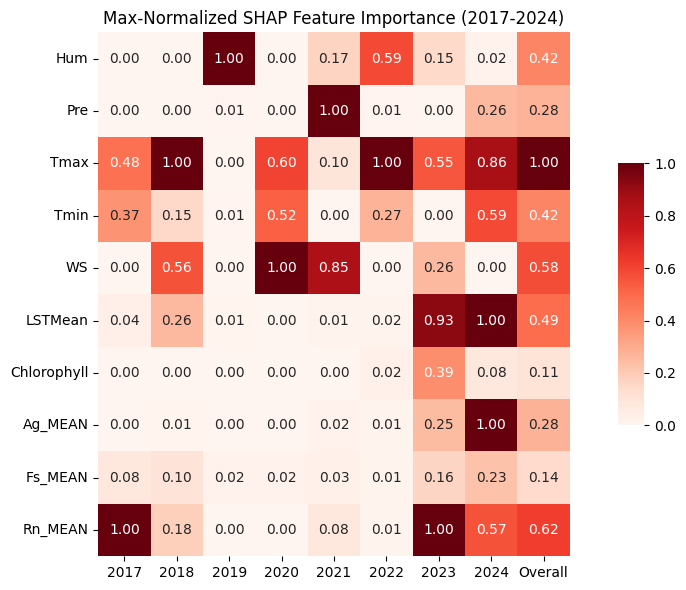

In [ ]:
# this is the heatmap, along with the added column at the end. 

fig, ax = plt.subplots(figsize=(10,6))

plt.rcParams.update({'font.size': 10})

sns.heatmap(df_save, cmap="Reds", annot=True, fmt=".2f", square=True, cbar=True, cbar_kws={"shrink": 0.5, "aspect": 10})

ax.set_ylabel(None)

ax.tick_params(axis="x",labelsize=10, rotation=0)

plt.title("Max-Normalized SHAP Feature Importance (2017-2024)")
plt.tight_layout()

plt.savefig("Max-Normalized SHAP Feature Importance (2017-2024) True Data")


In [210]:
df_save.to_csv("true_data_param_importance_2017_to_2024.csv")

#### Optimal Threshold for Feature Selection - True Data

In [19]:
df_save = pd.read_csv("true_data_param_importance_2017_to_2024.csv").reset_index(drop=True)

In [20]:
df_save = df_save.rename(columns={"Unnamed: 0":"Feature"})
df_save

,Feature,2017,2018,2019,2020,2021,2022,2023,2024,Overall
0,Hum,0.000000,0.000000,1.000000,0.000000,0.167429,0.586276,0.145411,0.018281,0.417583
1,Pre,0.000000,0.000000,0.005808,0.000000,1.000000,0.006711,0.000000,0.257247,0.276538
2,Tmax,0.476900,1.000000,0.000000,0.603373,0.095969,1.000000,0.553548,0.861866,1.000000
3,Tmin,0.372801,0.151455,0.006964,0.524036,0.000925,0.274519,0.000000,0.588112,0.417891
4,WS,0.000000,0.563410,0.001268,1.000000,0.845338,0.000000,0.257092,0.000000,0.580859
5,LSTMean,0.037551,0.257581,0.011079,0.000000,0.014790,0.015372,0.925166,0.997916,0.492079
6,Chlorophyll,0.000000,0.000000,0.000931,0.000000,0.000000,0.023518,0.393417,0.083062,0.109095
7,Ag_MEAN,0.000000,0.009151,0.000000,0.000000,0.018820,0.014312,0.247468,1.000000,0.280890
8,Fs_MEAN,0.081291,0.104863,0.017422,0.016473,0.026766,0.012050,0.162559,0.229178,0.141692
9,Rn_MEAN,1.000000,0.180990,0.000000,0.000000,0.079263,0.011925,1.000000,0.565328,0.617970


In [21]:
df_elbow = df_save[["Feature","Overall"]]
df_elbow

,Feature,Overall
0,Hum,0.417583
1,Pre,0.276538
2,Tmax,1.000000
3,Tmin,0.417891
4,WS,0.580859
5,LSTMean,0.492079
6,Chlorophyll,0.109095
7,Ag_MEAN,0.280890
8,Fs_MEAN,0.141692
9,Rn_MEAN,0.617970


In [ ]:
sorted_features = df_elbow["Overall"].sort_values(ascending=False)
x = range(1, len(sorted_features)+1)
kneedle = KneeLocator(x, sorted_features, curve='convex', direction='decreasing')
k = kneedle.knee
print(f"k = {k}")

df_sorted = df_elbow.sort_values("Overall", ascending=False)
top_features = df_sorted["Feature"].iloc[:k+1].tolist()
print(top_features)

k = 2
['Tmax', 'Rn_MEAN', 'WS']


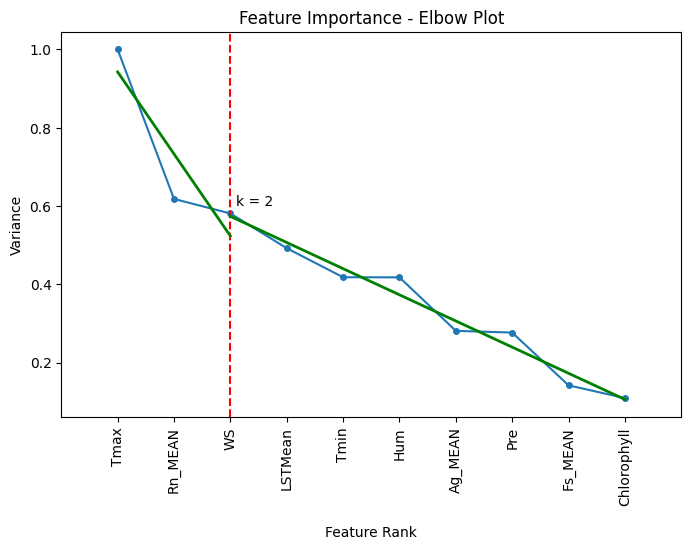

In [36]:
vals = df_elbow["Overall"].sort_values(ascending=False).values
features = df_sorted["Feature"].tolist()

plt.figure(figsize=(8,5))
plt.plot(range(1, len(vals)+1), vals, marker='o',markersize=4)
plt.xticks(range(1, len(vals)+1), features, rotation=90)

plt.axvline(x=3,linestyle="--",color="red") 

plt.text(3.1, vals[0]*0.60, "k = 2", rotation=0)
plt.xlim(0, len(vals)+1)

plt.xlabel("Feature Rank", labelpad=15)
plt.ylabel("Variance")
plt.title("Feature Importance - Elbow Plot")

# this wil help with interpretability
# array range for slope range
x = np.arange(1, len(vals)+1) 
x_1 = x[:3]
y_1 = vals[:3]
coef1 = np.polyfit(x_1, y_1, 1)
line1 = np.poly1d(coef1)
plt.plot(x_1, line1(x_1), color="green", linewidth=2)

x_2 = x[2:]
y_2 = vals[2:]
coef2 = np.polyfit(x_2, y_2, 1)
line2 = np.poly1d(coef2)
plt.plot(x_2, line2(x_2), color="green", linewidth=2)

plt.show()

In [37]:
print(f"Number of features in the final model: {len(top_features)}")
print(top_features)

Number of features in the final model: 3
['Tmax', 'Rn_MEAN', 'WS']


#### Bayesian Hyperparameter Tuning for TabNet Regressor

https://www.kaggle.com/code/liamhealy/bayesian-hyperparameter-tuning-in-python

Our objective function is RMSE (minimize RMSE).

1 iteration to be performed (backwards loocv):     
read this as [train] -> [target] 
1. [2017,2018,2019,2020,2021,2022,2023] -> [2024]
3. [2017,2018,2019,2020,2021,2022,2024] -> [2023]       
...     
8. [2018,2019,2020,2021,2022,2023,2024] -> [2017]

In [ ]:
# I am doing a quick check here to veryify all county col orderings are the same
# this is so I can keep an identifier when training and testing data, if it is ever needed for debugging. 
# counties_is_same_test = []
# for df in dfs:
# 	counties_is_same_test.append(df["County"])

# reference_series = counties_is_same_test[0]
# all_same = True

# for s in counties_is_same_test[1:]:
# 	if not reference_series.equals(s):
# 		all_same = False
# 		break

# print(all_same)
# county_names = df_2017["County"].copy()

# i removed this from loop 
# i want to actaully keep a clean features matrix
# 	it is very important that this remains constant (on the left)
# 	i never shift rows around, so this should work here
# 	df.insert(0, "County", county_names)

In [38]:
warnings.filterwarnings('ignore')
# Set Optuna logging level to WARNING (suppresses INFO messages)
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger('pytorch_tabnet').setLevel(logging.ERROR)

In [39]:
def create_objective(X_train, X_test, y_train, y_test):
	def objective(trial):
		params = {
			'n_d': trial.suggest_int('n_d', 8, 64),
			'n_a': trial.suggest_int('n_a', 8, 64),
			'n_steps': trial.suggest_int('n_steps', 3, 10),
			'gamma': trial.suggest_float('gamma', 1.0, 2.0),
			'n_independent': trial.suggest_int('n_independent', 1, 5),
			'n_shared': trial.suggest_int('n_shared', 1, 5),
			'lambda_sparse': trial.suggest_float('lambda_sparse', 1e-6, 1e-3, log=True),
			'momentum': trial.suggest_float('momentum', 0.01, 0.4),
			'clip_value': trial.suggest_float('clip_value', 0.5, 2.0),
			'optimizer_params': {'lr': trial.suggest_float('lr', 1e-4, 1e-1, log=True)},
			'scheduler_params': {
				'step_size': trial.suggest_int('step_size', 10, 50),
				'gamma': trial.suggest_float('scheduler_gamma', 0.5, 0.99)
			},
			'scheduler_fn': torch.optim.lr_scheduler.StepLR,
			'mask_type': 'entmax'
		}

		model = TabNetRegressor(
			n_d=params['n_d'],
			n_a=params['n_a'],
			n_steps=params['n_steps'],
			gamma=params['gamma'],
			n_independent=params['n_independent'],
			n_shared=params['n_shared'],
			lambda_sparse=params['lambda_sparse'],
			momentum=params['momentum'],
			clip_value=params['clip_value'],
			optimizer_fn=torch.optim.Adam,
			optimizer_params=params['optimizer_params'],
			scheduler_params=params['scheduler_params'],
			scheduler_fn=torch.optim.lr_scheduler.StepLR,
			mask_type=params['mask_type'],
			seed=25,
			verbose=0
		)

		# training and testing data is always diff for each iteration
		# there will be 8 iterations total. 
		model.fit(
			X_train = X_train,
			y_train = y_train,
			eval_set = [(X_test, y_test)],
			eval_metric=["rmse"],
			max_epochs = 100,
			patience = 20,
			batch_size = 256,
			virtual_batch_size = 128
		)

		y_pred = model.predict(X_test)
		rmse = np.sqrt(root_mean_squared_error(y_test, y_pred))

		return rmse
	return objective

In [40]:
def optimization_current_dataset(X_train, X_test, 
																 y_train, y_test, 
																 n_trials=50, 
																 study_name="tabnet_study"):
	'''
	This will be used for when I change my train/test data each iteration.
	I will append the dict result to the ``results`` list in the next cell.  
	'''
	# storing the current iteration reults.

	objective = create_objective(X_train, X_test, y_train, y_test)

	study = optuna.create_study(
		direction='minimize',
		# BO algorithm -> Tree-structured Parzen Estimator
		sampler=TPESampler(seed=25),
		study_name=study_name
  )

	# this is where the optimization takes place.
	study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

	best_params = study.best_params

	final_model = TabNetRegressor(
		n_d=best_params['n_d'],
		n_a=best_params['n_a'],
		n_steps=best_params['n_steps'],
		gamma=best_params['gamma'],
		n_independent=best_params['n_independent'],
		n_shared=best_params['n_shared'],
		lambda_sparse=best_params['lambda_sparse'],
		momentum=best_params['momentum'],
		clip_value=best_params['clip_value'],
		optimizer_params={'lr': best_params['lr']},
		scheduler_params={
				'step_size': best_params['step_size'],
				'gamma': best_params['scheduler_gamma']
		},
		scheduler_fn=torch.optim.lr_scheduler.StepLR,
		mask_type='entmax',
		seed=25,
		verbose=0
	)
    
	final_model.fit(
		X_train=X_train,
		y_train=y_train,
		eval_set=[(X_test, y_test)],
		eval_metric=['rmse'],
		max_epochs=200,
		patience=30,
		batch_size=256,
		virtual_batch_size=128
	)

	dict = {
		'best_params': best_params,
    'best_rmse': study.best_value,
		'model': final_model,
		'study': study
	}
	
	return dict

In [ ]:
# years = np.arange(2017, 2025)

# for test_idx in range(len(dfs) - 1, -1, -1):
# 	test_year = years[test_idx]
# 	train_years = np.delete(years, test_idx)
# 	print(f"testing: {test_year}")
# 	print(f"training: {train_years}")

In [44]:
# fixing shape issue
# keep consistent target col across dfs
clean_dfs = []

idx = 0
year = 2017
for df in dfs:
	df_year = dfs[idx]

	# -- SET TARGET COLUMN --
	df_year["target"] = df_year[f"Cases_normalized_{year}"]
	df_year = df_year.drop(columns=[f"Cases_normalized_{year}"])

	clean_dfs.append(df_year)

	idx += 1
	year += 1

In [46]:
clean_dfs[0]

,County_1,FIPS,Population,Hum_17,Pre_17,Tmax_17,Tmin_17,WS_17,LSTMean_2017,Chlorophyll_2017,Ag_MEAN_2017,Fs_MEAN_2017,Rn_MEAN_2017,target
0,Adams,17001,65435,83.489720,2.414575,28.878265,16.430389,3.828488,23.165,1.569802,0.79,0.79,0.76,1.513844
1,Alexander,17003,5761,92.409081,1.849715,29.800494,18.060720,2.966213,24.530,1.511613,0.74,0.83,0.67,0.000000
2,Bond,17005,16426,87.526342,2.671293,29.578461,16.664752,3.785671,23.920,1.791030,0.80,0.82,0.80,0.000000
3,Boone,17007,53544,94.299354,3.828716,26.579441,13.915454,3.932772,21.390,1.162529,0.80,0.80,0.76,1.868705
4,Brown,17009,6578,86.754199,2.218834,28.874032,15.834936,3.915250,23.030,1.746539,0.80,0.81,0.78,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Whiteside,17195,55175,90.371500,3.071367,27.478812,14.891202,3.578727,22.450,1.324900,0.82,0.81,0.74,0.000000
98,Will,17197,690743,91.886131,2.779096,27.584172,14.851429,3.660678,23.445,1.026980,0.78,0.73,0.75,0.144827
99,Williamson,17199,66597,90.827954,2.335025,29.802950,17.611845,2.927229,24.485,1.548734,0.79,0.80,0.77,0.000000
100,Winnebago,17201,282572,93.717256,3.636186,26.617381,14.118006,3.928297,21.845,1.156345,0.81,0.79,0.00,1.053811


In [57]:
clean_dfs_standardized = []

for df in clean_dfs:
    df_copy = df.copy()
    # Remove year suffixes: Hum_17 -> Hum, LSTMean_2017 -> LSTMean
    df_copy.columns = df_copy.columns.str.replace(r'_\d{2,4}$', '', regex=True)
    clean_dfs_standardized.append(df_copy)

clean_dfs = clean_dfs_standardized

In [58]:
results = []
# dfs_testing = [df_2017, df_2018, df_2019]

years = np.arange(2017, 2025)

# will run from 0 -- 2017 to 7 -- 2024 (0 indexed starts at 2017)
# reversing the index so iteration 1 starts with 
for test_idx in range(len(clean_dfs) - 1, -1, -1):
	# this is storing the top 13 parameters from the feature selection section
	top_features_copy = top_features.copy()

	test_df = clean_dfs[test_idx]

	train_dfs_list = [clean_dfs[i] for i in range(len(clean_dfs)) if i != test_idx]
	train_dfs = pd.concat(train_dfs_list, ignore_index=True)

	test_year = years[test_idx]
	train_years = [years[i] for i in range(len(clean_dfs)) if i != test_idx]

	X_train = train_dfs[top_features_copy].values
	y_train = train_dfs["target"].values.reshape(-1, 1)

	X_test = test_df[top_features_copy].values
	y_test = test_df["target"].values.reshape(-1, 1)

	# =========== above testing is done ===========

	iter_results_dict = optimization_current_dataset(X_train, X_test, y_train, y_test, study_name=f"tabnet_study_target_{test_year}")
	iter_results_dict["training"] = train_years
	iter_results_dict["testing"] = test_year 

	results.append(iter_results_dict)

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_rmse = 17.77891

Early stopping occurred at epoch 64 with best_epoch = 44 and best_val_0_rmse = 0.962

Early stopping occurred at epoch 25 with best_epoch = 5 and best_val_0_rmse = 3.33655

Early stopping occurred at epoch 53 with best_epoch = 33 and best_val_0_rmse = 0.40248

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 3.33625

Early stopping occurred at epoch 47 with best_epoch = 27 and best_val_0_rmse = 46.51121

Early stopping occurred at epoch 38 with best_epoch = 18 and best_val_0_rmse = 4.15084

Early stopping occurred at epoch 54 with best_epoch = 34 and best_val_0_rmse = 0.42209

Early stopping occurred at epoch 24 with best_epoch = 4 and best_val_0_rmse = 17.65144

Early stopping occurred at epoch 25 with best_epoch = 5 and best_val_0_rmse = 31.86402

Early stopping occurred at epoch 40 with best_epoch = 20 and best_val_0_rmse = 0.69827

Early stopping occurred at epoch 3

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 11.69808

Early stopping occurred at epoch 96 with best_epoch = 76 and best_val_0_rmse = 1.49847

Early stopping occurred at epoch 46 with best_epoch = 26 and best_val_0_rmse = 1.55229

Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_0_rmse = 1.85262

Early stopping occurred at epoch 26 with best_epoch = 6 and best_val_0_rmse = 6.41223

Early stopping occurred at epoch 29 with best_epoch = 9 and best_val_0_rmse = 71.67875

Early stopping occurred at epoch 47 with best_epoch = 27 and best_val_0_rmse = 2.08716

Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_0_rmse = 1.33134

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 15.93246

Early stopping occurred at epoch 25 with best_epoch = 5 and best_val_0_rmse = 43.44992

Early stopping occurred at epoch 31 with best_epoch = 11 and best_val_0_rmse = 1.79379

Early stopping occurred at epoch

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 48 with best_epoch = 28 and best_val_0_rmse = 31.9953

Early stopping occurred at epoch 25 with best_epoch = 5 and best_val_0_rmse = 15.5392

Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_rmse = 5.19929

Early stopping occurred at epoch 47 with best_epoch = 27 and best_val_0_rmse = 0.64033

Early stopping occurred at epoch 26 with best_epoch = 6 and best_val_0_rmse = 8.92982
Stop training because you reached max_epochs = 100 with best_epoch = 97 and best_val_0_rmse = 7.93986

Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_0_rmse = 0.65468

Early stopping occurred at epoch 29 with best_epoch = 9 and best_val_0_rmse = 0.4419

Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 18.99848

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 37.62365

Early stopping occurred at epoch 56 with best_epoch = 36 and best_val_0_rmse = 1.49085

Early stopping occurre

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 32.74511

Early stopping occurred at epoch 65 with best_epoch = 45 and best_val_0_rmse = 4.44243

Early stopping occurred at epoch 35 with best_epoch = 15 and best_val_0_rmse = 3.309

Early stopping occurred at epoch 44 with best_epoch = 24 and best_val_0_rmse = 0.38643

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 7.1362
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_val_0_rmse = 7.50112

Early stopping occurred at epoch 47 with best_epoch = 27 and best_val_0_rmse = 2.34818

Early stopping occurred at epoch 57 with best_epoch = 37 and best_val_0_rmse = 0.36605

Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_rmse = 20.43923

Early stopping occurred at epoch 26 with best_epoch = 6 and best_val_0_rmse = 30.78785

Early stopping occurred at epoch 47 with best_epoch = 27 and best_val_0_rmse = 1.53705

Early stopping occurr

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 20 with best_epoch = 0 and best_val_0_rmse = 32.63676

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 10.38538

Early stopping occurred at epoch 46 with best_epoch = 26 and best_val_0_rmse = 7.10554

Early stopping occurred at epoch 29 with best_epoch = 9 and best_val_0_rmse = 0.4293

Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_rmse = 0.47147
Stop training because you reached max_epochs = 100 with best_epoch = 98 and best_val_0_rmse = 5.42902

Early stopping occurred at epoch 42 with best_epoch = 22 and best_val_0_rmse = 1.39553

Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_rmse = 0.51944

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 4.64009

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 14.63299

Early stopping occurred at epoch 43 with best_epoch = 23 and best_val_0_rmse = 0.49001

Early stopping occurre

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 3.51634

Early stopping occurred at epoch 49 with best_epoch = 29 and best_val_0_rmse = 2.91417

Early stopping occurred at epoch 25 with best_epoch = 5 and best_val_0_rmse = 3.62547

Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_0_rmse = 2.15208

Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 2.45354

Early stopping occurred at epoch 44 with best_epoch = 24 and best_val_0_rmse = 81.98836

Early stopping occurred at epoch 65 with best_epoch = 45 and best_val_0_rmse = 2.12242

Early stopping occurred at epoch 30 with best_epoch = 10 and best_val_0_rmse = 2.12581

Early stopping occurred at epoch 29 with best_epoch = 9 and best_val_0_rmse = 6.22033

Early stopping occurred at epoch 27 with best_epoch = 7 and best_val_0_rmse = 19.60375

Early stopping occurred at epoch 46 with best_epoch = 26 and best_val_0_rmse = 2.13004

Early stopping occurred at epoch 2

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 21 with best_epoch = 1 and best_val_0_rmse = 13.98184

Early stopping occurred at epoch 39 with best_epoch = 19 and best_val_0_rmse = 2.65267

Early stopping occurred at epoch 40 with best_epoch = 20 and best_val_0_rmse = 2.25595

Early stopping occurred at epoch 38 with best_epoch = 18 and best_val_0_rmse = 2.21653

Early stopping occurred at epoch 24 with best_epoch = 4 and best_val_0_rmse = 2.12921

Early stopping occurred at epoch 32 with best_epoch = 12 and best_val_0_rmse = 70.15785

Early stopping occurred at epoch 77 with best_epoch = 57 and best_val_0_rmse = 2.06525

Early stopping occurred at epoch 38 with best_epoch = 18 and best_val_0_rmse = 2.37488

Early stopping occurred at epoch 38 with best_epoch = 18 and best_val_0_rmse = 4.87518

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 45.33434

Early stopping occurred at epoch 50 with best_epoch = 30 and best_val_0_rmse = 2.06337

Early stopping occurred at epoc

  0%|          | 0/50 [00:00<?, ?it/s]


Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_rmse = 28.85492

Early stopping occurred at epoch 34 with best_epoch = 14 and best_val_0_rmse = 1.28342

Early stopping occurred at epoch 58 with best_epoch = 38 and best_val_0_rmse = 2.32603

Early stopping occurred at epoch 38 with best_epoch = 18 and best_val_0_rmse = 1.51231

Early stopping occurred at epoch 22 with best_epoch = 2 and best_val_0_rmse = 1.69921

Early stopping occurred at epoch 33 with best_epoch = 13 and best_val_0_rmse = 65.64769

Early stopping occurred at epoch 36 with best_epoch = 16 and best_val_0_rmse = 3.02648

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 1.67106

Early stopping occurred at epoch 28 with best_epoch = 8 and best_val_0_rmse = 4.47523

Early stopping occurred at epoch 23 with best_epoch = 3 and best_val_0_rmse = 12.42053

Early stopping occurred at epoch 77 with best_epoch = 57 and best_val_0_rmse = 3.12595

Early stopping occurred at epoch 

In [59]:
print("X_train:", X_train.shape, "y_train:", y_train.shape)

X_train: (714, 3) y_train: (714, 1)


In [60]:
# save models and everything as pickle file 
with open('true_data_tabnet_results.pkl', 'wb') as f:
	pickle.dump(results, f)

In [61]:
# to load results later
with open('true_data_tabnet_results.pkl', 'rb') as f:
	pickle_results = pickle.load(f)

#### Best Model:

In [64]:
for i, n in enumerate(pickle_results):
	print(f"index: {i}")
	print(f"best rmse: {n["best_rmse"]}")
	print("")

index: 0
best rmse: 0.6034201188054769

index: 1
best rmse: 1.1440322264435607

index: 2
best rmse: 0.6647593019938296

index: 3
best rmse: 0.6050214576699392

index: 4
best rmse: 0.5517652225117441

index: 5
best rmse: 1.4551079022366262

index: 6
best rmse: 1.421959736178361

index: 7
best rmse: 1.0992703289270234



In [65]:
best_model = results[4]
best_model

{'best_params': {'n_d': 49,
  'n_a': 38,
  'n_steps': 10,
  'gamma': 1.415029275480764,
  'n_independent': 3,
  'n_shared': 5,
  'lambda_sparse': 2.1204047265253847e-05,
  'momentum': 0.39886589131490846,
  'clip_value': 1.56255760967592,
  'lr': 0.05362096613704142,
  'step_size': 39,
  'scheduler_gamma': 0.5783545612692614},
 'best_rmse': 0.5517652225117441,
 'model': TabNetRegressor(n_d=49, n_a=38, n_steps=10, gamma=1.415029275480764, cat_idxs=[], cat_dims=[], cat_emb_dim=[], n_independent=3, n_shared=5, epsilon=1e-15, momentum=0.39886589131490846, lambda_sparse=2.1204047265253847e-05, seed=25, clip_value=1.56255760967592, verbose=0, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.05362096613704142}, scheduler_fn=<class 'torch.optim.lr_scheduler.StepLR'>, scheduler_params={'step_size': 39, 'gamma': 0.5783545612692614}, mask_type='entmax', input_dim=3, output_dim=1, device_name='auto', n_shared_decoder=1, n_indep_decoder=1, grouped_features=[]),
 'study': <opt

In [66]:
best_model["model"]

,n_d,49
,n_a,38
,n_steps,10
,gamma,1.415029275480764
,cat_idxs,[]
,cat_dims,[]
,cat_emb_dim,[]
,n_independent,3
,n_shared,5
,epsilon,1e-15
,momentum,0.39886589131490846


In [67]:
model = best_model["model"]

print(f"best model training years: { [int(val) for val in best_model["training"]] }")
print(f"best model test year: {best_model["testing"]}")

best model training years: [2017, 2018, 2019, 2021, 2022, 2023, 2024]
best model test year: 2020


In [68]:
top_features_copy = top_features.copy()

X_test = test_df[top_features_copy].values
y_test = test_df["target"].values.reshape(-1, 1)

y_pred = model.predict(X_test).reshape(-1)
y_true = y_test.reshape(-1)

In [69]:
rmse = root_mean_squared_error(y_true, y_pred)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

In [70]:
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R^2: {r2}")

RMSE: 1.252010649625942
MAE: 0.5567291491335823
R^2: -0.07305121423573091


In [71]:
print(y_true.mean())
print(y_true.std())
print(y_true.var())

0.40268195944829416
1.20864232296155
1.4608162648538916
